In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import(
    train_test_split,
    cross_val_score,
)

from sklearn.linear_model import(
    LassoCV,
    ElasticNetCV,
    LinearRegression
)

from sklearn.feature_selection import(
    VarianceThreshold,
    chi2,
    SelectKBest,
)

from sklearn.ensemble import(
    RandomForestRegressor,
    GradientBoostingRegressor
)

from sklearn.metrics import(
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score
)

from scipy.stats import skew


#   Inter-Notebook Loader 
###  This code will load other notebooks in the same directory

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        print("No path")
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % self.path)

        # load the notebook object
        with io.open(self.path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [287]:
feature_transform_path = os.getcwd() + "/feature_transform.ipynb"
nb = NotebookLoader(path=feature_transform_path)

In [288]:
feature_transform = nb.load_module(feature_transform_path)

importing Jupyter notebook from /Users/deangoldman/class/nycdsa/Housing/feature_transform.ipynb


/Users/deangoldman/class/nycdsa/Housing/feature_transform.ipynb:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  "metadata": {
/Users/deangoldman/class/nycdsa/Housing/feature_transform.ipynb:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  "collapsed": true
/Users/deangoldman/class/nycdsa/Housing/feature_transform.ipynb:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [289]:
# import dataframe from feature_transform nb
df = feature_transform.train_numeric

In [342]:
msun_nb_path = os.getcwd() + "/msun_house_price_kaggle.ipynb"
nb = NotebookLoader(path=msun_nb_path)
msun_nb = nb.load_module(msun_nb_path)

house = msun_nb.House('train.csv', 'test.csv', 'data_description.txt').train_data
# house = ordinal_to_numeric(house.train_data)
house[house.select_dtypes(['object']).columns] = house.select_dtypes(['object']).apply(lambda x: x.astype('category'))
house_dummies = pd.get_dummies(house)
house_dummies['GarageYrBlt'].fillna(house_dummies['YearBuilt'], inplace=True)
house_dummies = house_dummies.fillna(0)

importing Jupyter notebook from /Users/deangoldman/class/nycdsa/Housing/msun_house_price_kaggle.ipynb


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/internals.py:594: RuntimeWarning: Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/internals.py:594: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))


# Categorical dataframe to binary encoding using category_encoders library

In [331]:
import category_encoders as ce
def to_binary(df):
    encoder = ce.binary.BinaryEncoder(cols=list(df.select_dtypes(['category']).columns))
    encoder.fit(df)

    df_binary = encoder.transform(df)
    df_binary.set_index("Id", inplace=True)
    df_binary.fillna(0, inplace=True)
    return df_binary
house = to_binary(house)

In [412]:
# Basic dummy variable dataframe

train = pd.read_csv("train.csv")
numeric_feats = train.dtypes[train.dtypes != "object"].index

# Applying logarithmic transform to skewed features
# This code was pulled from Alexandru Papiu:
# https://www.kaggle.com/apapiu/regularized-linear-models

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
train[skewed_feats] = np.log1p(train[skewed_feats])

# Getting dummy variables
train_dummies = pd.get_dummies(train, drop_first=True)
train_dummies['GarageYrBlt'].fillna(train_dummies['YearBuilt'], inplace=True)
train_dummies = train_dummies.fillna(train_dummies.mean())

# Mapping ordered categorical variables
Some of the features in the data set are categorically ordered i.e; Excellent, Good, Fair,...  
To have a label encoding consistent with category meanings, run this mapping.  
Otherwise you will get something like this:  
  
     
"Good" = 4  
"Average" = 5  
"Excellent" = 1  
"Poor" = 2  
  
This affects variable correlation- and I bet it also affects variable importance during modeling.  
To see this demonstrated: Don't run the code below, and notice in the correlation plot that "ExterQual" is inversely correlated with "OverallQual" and "SalePrice"- which makes no sense.

In [9]:
def ordinal_to_numeric(df):
    for i in range(len(df.columns)-1):
        is_cat = df.iloc[:,i].values.any() in ("Gd","Ex","TA","Fa","Po")
        if is_cat == True:
            df[df.columns[i]] = df[df.columns[i]].map({"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1})
    return df

In [13]:
### Unskew 

def unskew(df):
    numeric_feats = df.select_dtypes(include=["float64","int64"]).columns

    # Applying logarithmic transform to skewed features
    # This code was pulled from Alexandru Papiu:
    # https://www.kaggle.com/apapiu/regularized-linear-models

    skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    df[skewed_feats] = np.log1p(df[skewed_feats])
    return df

In [291]:
### Correlation Plots

def corrgraphs(df):
    neg = df.corr()[df.corr() < -0.25]
    neg = neg.dropna(how="all", axis=1)
    neg = neg.dropna(how="all", axis=0)
    pos = df.corr()[df.corr() > 0.5]
    pos = pos[pos < 1.0]
    pos = pos.dropna(how="all", axis=1)
    pos = pos.dropna(how="all", axis=0)
    return (neg, pos)
neg, pos = corrgraphs(df)

/Users/deangoldman/Library/Python/3.6/lib/python/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


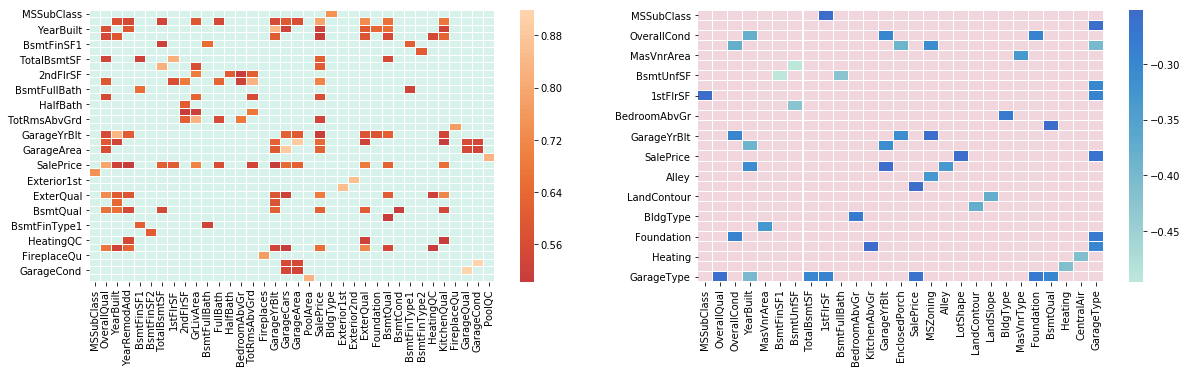

In [292]:
def plot_corrgraphs(neg, pos):
    fig, axs = plt.subplots(ncols=2, figsize=(20,5))
    pos_heatmap = sns.heatmap(pos, center=0, linewidths=0.01, ax=axs[0])
    pos_heatmap.set(axis_bgcolor="#D6F2EB")
    neg_heatmap = sns.heatmap(neg, center=0, linewidths=0.01, ax=axs[1])
    neg_heatmap.set(axis_bgcolor="#F2D6DD")
    return
plot_corrgraphs(neg, pos)

In [34]:
# le = LabelEncoder()
# le.fit(train["KitchenQual"])
# list(le.classes_)
# tdf = pd.DataFrame([le.transform(train["KitchenQual"]),
#                    train["KitchenQual"],
#                    train["SalePrice"]]).T
# tdf.rename(columns={0:"Encoded", 1:"Original", 2:"SalePrice"}, inplace=True)

/Users/deangoldman/Library/Python/3.6/lib/python/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


[None]

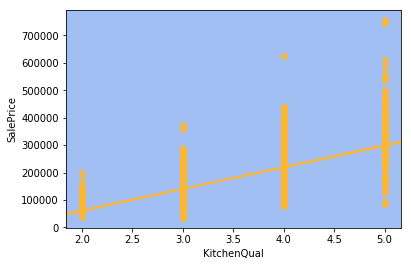

In [279]:
# Example plot
regplot = sns.regplot(x = 'KitchenQual', y = 'SalePrice', data = df, color = '#FFB733')
regplot.set(axis_bgcolor="#A2BFF4")

In [95]:
# Variance Inflation Factor Filter
from statsmodels.stats.outliers_influence import variance_inflation_factor    
def vif_filter(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
#             print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

#     print('Remaining variables:')
#     print(X.columns[variables])
    return X[cols[variables]]

In [416]:
# Full dataframe into Train-test Split
def full_set_split(df):
#     df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]
#     df.drop(["TotalBsmtSF","1stFlrSF","2ndFlrSF"], axis=1, inplace=True)
    X = df.drop(["SalePrice","Id"], axis=1)
#     X = vif_filter(X, thresh=5)
    y = df["SalePrice"]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    return (X_train, X_test, y_train, y_test)

## Switch dataframes here

In [417]:
df = unskew(train_dummies)
X_train, X_test, y_train, y_test = full_set_split(df)

In [405]:
# plt.hist(train_dummies["SalePrice"])

# Modeling

In [418]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [422]:
lm.score(X_test, y_test)

0.9224684269916984

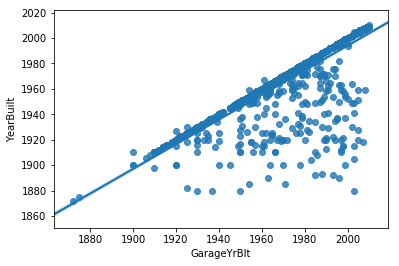

In [421]:
sns.regplot(train_dummies['GarageYrBlt'], y=df["YearBuilt"])

In [132]:
# Combine-able
# -------------
# MiscFeature x MiscVal 
# PoolQC PoolArea HasPool > poolScore?
# BsmtQual combine with other Bsmt features
# MSSubClass? x HouseStyle
# Combination to evaluate type of lot LotConfig, Area, ...

# Ordinal
# -------------
# Fence
# LandSlope
# BsmtFinType1
# BsmtFinType2
# BsmtExposure
# GarageFinish

# Categorical -> Dummies -> Ordinal?
# -------------
# Utilities
# RoofMatl
# RoofStyle
# MiscFeature
# Street
# Alley
# GarageType
# SaleType
# SaleCondition
# MSSubClass
# MSZoning
# LotShape
# Neighborhood
# Condition 1
# Condition 2
# BldgType
# Exterior1st
# Foundation
# Heating
# Functional

# Interpolate
# -------------
# GarageYrBlt = YearBuilt


# df["MiscVal"]

In [337]:
# coefs = pd.DataFrame(X_train.columns, lm.coef_).reset_index().rename(index=str, columns={"index":"coef", 0:"Feature"})
# coefs[coefs["coef"] > .01]

In [423]:
# Calculate RMSE
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 3))
    return(rmse)

In [424]:
# Lasso CV

model_lasso = LassoCV(normalize=True, cv=6).fit(X_train, y_train)
print(rmse_cv(model_lasso).mean())
model_lasso.score(X_test, y_test)

0.14740471346737508


0.9087654610179481

### Lasso CV Scores
The dataframe from msun_nb with ordinal imputation, skew correction, and binary encoding scores .88  
The train.csv -> dummies scores .89  
The dataframe (df) from feature_transform.ipynb scores .90

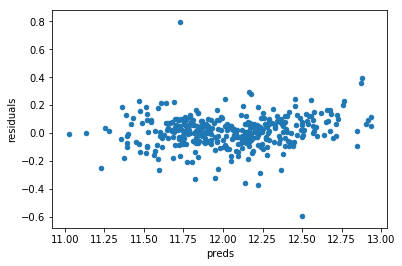

In [425]:
preds = pd.DataFrame({"preds":model_lasso.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [426]:
# Elastic Net CV

elastic_net = ElasticNetCV(alphas=[.001])
elastic_net.fit(X_train, y_train)
train_test(elastic_net, X_train, X_test, y_train, y_test)

ElasticNetCV(alphas=[0.001], copy_X=True, cv=None, eps=0.001,
       fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)
Train
-------------------------
R2: 0.9089702500056865
RMSE: 0.11460617998039403
Test
-------------------------
R2: 0.9100076141890883
RMSE: 0.11143573694333107


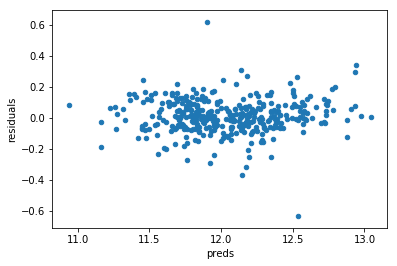

In [427]:
preds = pd.DataFrame({"preds":elastic_net.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [376]:
# Random Forest

rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train, y_train)
print(rmse_cv(rf).mean())
rf.score(X_test, y_test)

0.15247402599364673


0.8755568566951675

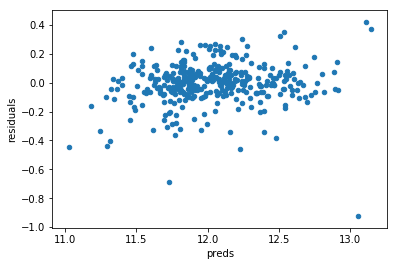

In [409]:
preds = pd.DataFrame({"preds":rf.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [431]:
# Gradient Boosting

gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.085,
                                   max_depth=2, max_features=10,loss="huber")
gboost.fit(X_train, y_train)

# Prints R2 and RMSE scores
def get_score(pred, y):
    print('R2: {}'.format(r2_score(pred, y)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(pred, y))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    pred_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    print("Train")
    print("-"*25)
    # Printing train scores
    get_score(pred_train, y_trn)
    pred_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    print("-"*25)
    get_score(pred_test, y_tst)

train_test(gboost, X_train, X_test, y_train, y_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.085, loss='huber', max_depth=2,
             max_features=10, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
Train
-------------------------
R2: 0.9578130444976233
RMSE: 0.07884999060269425
Test
-------------------------
R2: 0.909844139403968
RMSE: 0.1116943988232536


In [401]:
# PCA workflow not being used atm.

# pca = PCA()
# # scaled_data = scale(X_train.T)
# # pca.fit(scaled_data)    

# pca.fit(scale(X_train))
# pca_data = pca.transform(scale(X_train))

# per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
# labels = ["PC" + str(x) for x in range(1, len(per_var) + 1)]
# plt.bar(left=range(1,6), height=per_var[:5], tick_label=labels[:5])
# plt.show()

# pca_df = pd.DataFrame(pca_data)
# plt.scatter(pca_df[0], pca_df[1], pca_df[3], c=["red","blue","green"])